In [1]:
from google.colab import drive
from tensorflow import keras
from tensorflow.keras import models,layers,optimizers,losses
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tarfile
from keras.initializers import RandomNormal
from keras.constraints import Constraint

In [2]:
from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from tensorflow import keras
from keras import backend
from keras.models import Sequential
from keras.layers import Dense,Reshape,Flatten,Conv2D,Conv2DTranspose,LeakyReLU,ReLU,BatchNormalization
from keras.initializers import RandomNormal

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = np.load("/content/drive/MyDrive/dataset_2.npy")

In [4]:
def define_discriminator(image_length,image_channels):
  init = RandomNormal(stddev=0.02)
  model = Sequential()

  model.add(Conv2D(64,3, strides=(2,2), padding='same',use_bias=False, kernel_initializer=init,input_shape=(image_length,image_length,image_channels)))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128,3, strides=(2,2), padding='same',use_bias=False, kernel_initializer=init))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(256,5, strides=(2,2), padding='same',use_bias=False, kernel_initializer=init))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(512,5, strides=(2,2), padding='same',use_bias=False, kernel_initializer=init))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.2))
 
  model.add(Conv2D(1,4,strides=(1,1),padding='valid',use_bias=False,kernel_initializer=init))
  model.add(Flatten())
  model.add(layers.Activation('sigmoid'))
  return model

In [5]:
def define_generator(latent_dim):
	init = RandomNormal(stddev=0.02)
	model = Sequential()
	n_nodes = 1024 * 4*4
	model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
	model.add(BatchNormalization())
	model.add(ReLU())
	model.add(Reshape((4,4,1024)))
	
	model.add(Conv2DTranspose(512,5, strides=(2,2), padding='same',use_bias=False, kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(ReLU())
 
	model.add(Conv2DTranspose(256,5, strides=(2,2), padding='same',use_bias=False, kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(ReLU())
 
	model.add(Conv2DTranspose(128,3, strides=(2,2), padding='same',use_bias=False, kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(ReLU())

	model.add(Conv2DTranspose(3,3,strides=(2,2),activation='tanh', padding='same',use_bias=False,kernel_initializer=init))
	return model

In [6]:
class DCGAN(keras.Model):
    def __init__(self,seed_size,image_length,image_channels):
        super(DCGAN,self).__init__()

        self.generator = define_generator(seed_size)
        self.discriminator = define_discriminator(image_length,image_channels)
        self.seed_size = seed_size
           
    def generator_loss(self,fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)

    def discriminator_loss(self,real_output, fake_output,noise=0.1):
        real_loss = cross_entropy(tf.ones_like(real_output)*(1-noise), real_output) 
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss
    
    def compile(self,generator_optimizer,discriminator_optimizer):
        super(DCGAN, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        
    @tf.function    
    def train_step(self,data):
        batch_size = tf.shape(data)[0]
        seed = tf.random.normal(shape=(batch_size,self.seed_size))
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_image = self.generator(seed, training = True)
            real_output = self.discriminator(data,training = True)
            fake_output = self.discriminator(generated_image,training = True) 
      
            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output,fake_output)

            generator_grad = gen_tape.gradient(gen_loss,self.generator.trainable_variables)
            discriminator_grad = disc_tape.gradient(disc_loss,self.discriminator.trainable_variables)

            self.generator_optimizer.apply_gradients(zip(generator_grad,self.generator.trainable_variables))
            self.discriminator_optimizer.apply_gradients(zip(discriminator_grad,self.discriminator.trainable_variables))
        
        return {
            "generator loss": gen_loss,
            "discriminator_loss": disc_loss
        }

In [7]:
cross_entropy=keras.losses.BinaryCrossentropy()

In [8]:
image_length = 64
image_channels = 3
batch_size = 128
seed_size = 128

In [9]:
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5)

dcgan = DCGAN(seed_size,image_length,image_channels)
dcgan.compile(generator_optimizer,discriminator_optimizer)

In [10]:
fixed_seed = np.load('/content/drive/MyDrive/seed.npy')

In [11]:
dcgan.generator.load_weights('/content/drive/MyDrive/generator_weights.h5')
dcgan.discriminator.load_weights('/content/drive/MyDrive/discriminator_weights.h5')

In [16]:
def generate_faces(step,n):
  noise = tf.random.normal([144,seed_size])
  generated_images = dcgan.generator.predict(noise)
  fig = plt.figure(figsize=(12,12))
  for i in range(generated_images.shape[0]):
      plt.subplot(n,n,i+1)
      plt.imshow((generated_images[i,:,:,:]*0.5+0.5))
      plt.axis("off")
  #filename = '/content/drive/MyDrive/DCGANMAIN/generated_images_e%03d.png' % (step+1)
  #plt.savefig(filename)
  plt.show()
  plt.close()

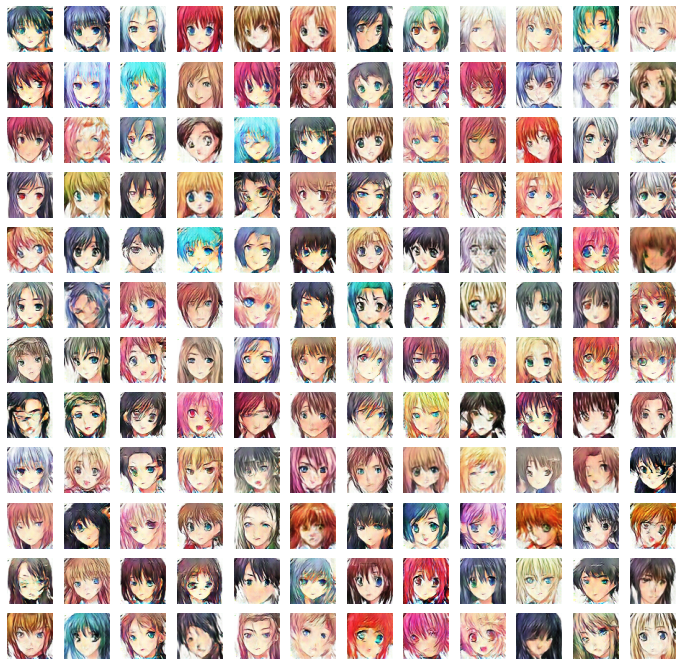

In [17]:
generate_faces(0,12)

In [ ]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

class save_images(keras.callbacks.Callback):
    def __init__(self,noise):
        super(keras.callbacks.Callback,self).__init__()
        self.noise = noise
    
    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator.predict(self.noise)
        fig = plt.figure(figsize=(12,12))
        for i in range(generated_images.shape[0]):
            plt.subplot(5,5,i+1)
            plt.imshow((generated_images[i,:,:,:]*0.5+0.5))
            plt.axis("off")
        filename = '/content/drive/MyDrive/DCGANMAIN/generated_images_e%03d.png' % (epoch+1)
        plt.savefig(filename)
        plt.show()
        plt.close()

class checkpoint_callback(keras.callbacks.Callback):
    def __init__(self):
        super(keras.callbacks.Callback, self).__init__()
    def on_epoch_end(self, epoch, logs=None):
        self.model.generator.save_weights('/content/drive/MyDrive/DCGANMAIN/generator_weights.h5')
        self.model.discriminator.save_weights('/content/drive/MyDrive/DCGANMAIN/discriminator_weights.h5')

In [ ]:
dcgan.fit(dataset,epochs=100,batch_size=128,callbacks=[save_images(noise=fixed_seed),checkpoint_callback()])
  
  

Output hidden; open in https://colab.research.google.com to view.

In [18]:
def interpolate_points(p1,p2,n_steps=20):
  ratios = np.linspace(0,1,n_steps)
  vectors = []
  for ratio in ratios:
    v = (1.0 - ratio) * p1 + ratio * p2
    vectors.append(v)
  return np.asarray(vectors)

In [19]:
def plot_generated(images):
  figure = plt.figure(figsize=(20,20))
  for i in range(16*8):
    plt.subplot(16,8,i+1)
    plt.axis('off')
    image = np.squeeze(images[i])
    plt.imshow(image)
    #filename = '/content/drive/MyDrive/GIF/gif_e%03d.png' % (i+1)
    #plt.savefig(filename)

In [ ]:
from PIL import Image
import glob
def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
    frame_one = frames[0]
    frame_one.save("/content/drive/MyDrive/progressanime.gif", format="GIF", append_images=frames,save_all=True, duration=1, loop=1)

In [ ]:
def multi_interpolation(points,n_steps):
  res = interpolate_points(points[0],points[1]) 
  for i in range(2,points.shape[0]):
    inter = interpolate_points(points[i-1],points[i])
    res = np.concatenate((res,inter))
  return res

In [ ]:
def interpolate_one_point(p1,ecart,n_steps=20):
    ratios = np.linspace(0,1,n_steps)
    vectors = []
    for ratio in ratios:
      v = (1.0 - ratio) * (p1-ecart*np.ones(p1.shape))+ ratio * (p1+ecart*np.ones(p1.shape))
      vectors.append(v)
    return np.asarray(vectors)

In [ ]:
points = np.random.normal(size=(1,seed_size))
#interpolated = multi_interpolation(points,10)
X = dcgan.generator.predict()
X = X*0.5+0.5
plot_generated(X)
#make_gif('/content/drive/MyDrive/GIF')

In [ ]:
point = np.random.normal(size=(1,seed_size))
modifs = []
for i in range(point.shape[1]):
  ix = np.random.randint(0,127,12)
  modified_i_less = np.copy(point)
  modified_i_less[0,i] = -5
  modified_i_more = np.copy(point)
  modified_i_more[0,i] = 5
  modifs.append(modified_i_less)
  modifs.append(modified_i_more)

modifs = np.asarray(modifs)
print(modifs.shape)

(256, 1, 128)


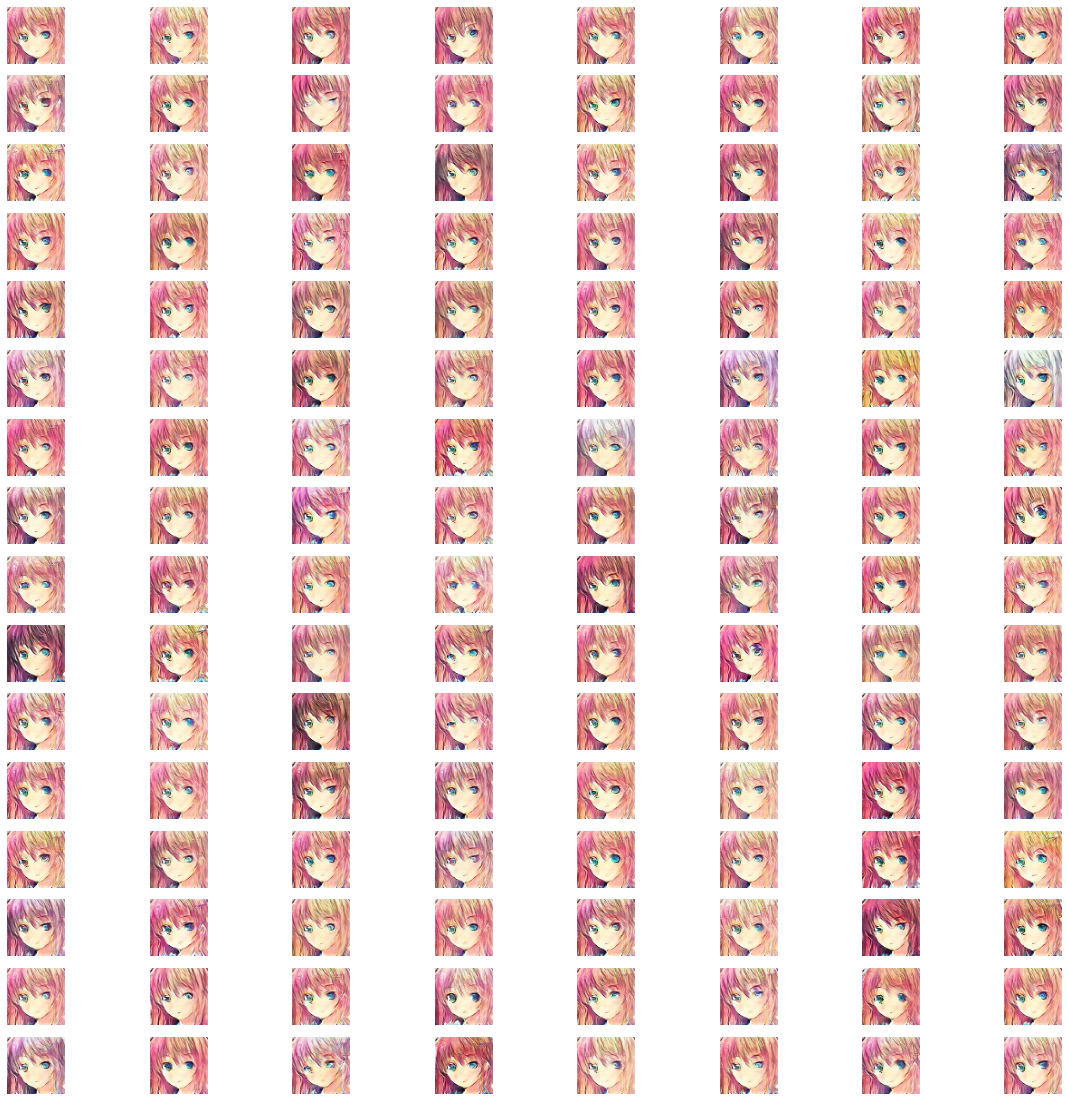

In [ ]:
ori = dcgan.generator.predict(point)
ori = ori *0.5 + 0.5
images = [ori]
for image in modifs:
  res = dcgan.generator.predict(image)
  res = res*0.5 + 0.5
  images.append(res)
plot_generated(images)
plt.show()

In [ ]:
make_gif("/content/drive/MyDrive/DCGANMAIN")